In [1]:
import numpy as np

config_file = '/Users/samsonkoelle/tunatostada/experiments/configs/malonaldehyde_full.json'
import json
config = {}
with open(config_file) as f:
    config.update(json.load(f))

args = {}
args['outdir'] = '/Users/samsonkoelle/'
args['raw_data'] = '/Users/samsonkoelle/thesis_data/raw_data/malonaldehyde.mat'
args['nreps'] = 1
args['mflasso'] = True
args['name'] = "mal_full_mf"
config.update(args)

In [2]:
np.random.seed(0)

In [3]:
#"(
#diffusion_time * (diffusion_time * np.pi * 4)**(d
#im/2))**(0.5)
dim = 2
diffusion_time = 1.
(diffusion_time * (diffusion_time * np.pi*4)**(dim/2))**(0.5)

3.5449077018110318

In [4]:
#hparams.n_neighbors
#shared_index = np.asarray([ 182 , 660  ,787 ,1220 ,1460])#np.intersect1d(asdf,angle_indices[:100])

In [5]:
from montlake.vendor.tfcompat.hparam import HParams
from montlake.exec.run_exp import subset_data

import itertools
import numpy as np
import scipy

In [6]:
hparams = HParams(**config)
#    if hparams.data_sub == None:
#positions, randomindices = subset_data(hparams)
angle_indices = np.load('/Users/samsonkoelle/thesis_data/raw_data/malonaldehydeindices022119.npy')
positions_all = scipy.io.loadmat(hparams.raw_data)
positions = positions_all['R'][angle_indices]

hparams.radius = 3.545

In [7]:
positions[0]

array([[-0.15995727, -0.94001211,  0.97173461],
       [ 0.13830514,  0.42331606,  0.26343923],
       [ 0.53982645,  0.26770031, -1.17335364],
       [ 0.44526224,  1.26218395, -1.89167955],
       [-0.9691536 , -1.03634848,  1.80260786],
       [ 0.57393436, -1.74997932,  0.6922344 ],
       [-0.48084874,  1.282775  ,  0.60722686],
       [ 1.01786975,  0.64555854,  0.82544162],
       [ 1.02877483, -0.79531041, -1.44771136]])

In [8]:
#randomindices
#np.where(randomindices == 61)[0]

In [9]:
# randomindices.sort()
# randomindices[:100]

In [10]:
#indices = np.where(np.isin(randomindices, shared_index))[0]

In [11]:
#indices

In [12]:
#hparams.radius = 6.

In [13]:
# export 

from montlake.atomgeom.features import get_features,get_D_feats_feats
from montlake.atomgeom.utils import get_atoms_4
from montlake.simulations.rigidethanol import get_rigid_ethanol_data
from montlake.utils.utils import get_234_indices, get_atoms3_full, get_atoms4_full, data_stream_custom_range, get_cosines
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.gradients.estimate import get_grads_pullback
from montlake.statistics.normalization import normalize_L212
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.optimization.utils import get_selected_function_ids,get_selected_functions_lm2
from montlake.utils.replicates import Replicate, get_supports_brute,get_supports_lasso

from megaman.embedding import SpectralEmbedding

import dill as pickle
import os
import sys
import numpy as np
import itertools
from itertools import permutations,combinations
from sklearn.decomposition import TruncatedSVD
import pathos
from pathos.multiprocessing import ProcessingPool as Pool

In [14]:
    d = hparams.d
    n_components = hparams.n_components
    atoms2_feat = hparams.atoms2_feat
    atoms3_feat = hparams.atoms3_feat
    atoms4_feat = hparams.atoms4_feat
    atoms2_dict = hparams.atoms2_dict
    atoms3_dict = hparams.atoms3_dict
    atoms4_dict = hparams.atoms4_dict
    diagram = hparams.diagram

    ii = np.asarray(hparams.ii)
    jj = np.asarray(hparams.jj)
    outfile = hparams.outdir + '/' + hparams.name + 'results_mflasso'
    print('loading geometric features')
    natoms = positions.shape[1]
    n = positions.shape[0]
    atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2)))
    atoms2full = atoms2
    atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3)))
    atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4)))
    atoms3full = get_atoms3_full(atoms3)
    atoms4full = get_atoms4_full(atoms4)

    if atoms2_feat:
        atoms2_feats = atoms2full
    else:
        atoms2_feats = np.asarray([])

    if atoms3_feat:
        atoms3_feats = atoms3full
    else:
        atoms3_feats = np.asarray([])

    if atoms4_feat:
        atoms4_feats = atoms4full
    else:
        atoms4_feats = np.asarray([])

    print('computing featurization')
    cores = pathos.multiprocessing.cpu_count() - 1
    pool = Pool(cores)
    print('feature dimensions 234',atoms2_feats.shape, atoms3_feats.shape,atoms4_feats.shape)
    pool.close()
    pool.restart()
    results = pool.map(lambda i: get_features(positions[i],
                               atoms2 = atoms2_feats,
                               atoms3 = atoms3_feats,
                               atoms4 = atoms4_feats),
        data_stream_custom_range(list(range(n))))
    data = np.vstack([np.hstack(results[i]) for i in range(n)])
    #data = data - np.mean(data, axis = 0)
    svd = TruncatedSVD(n_components=50)
    data_svd = svd.fit_transform(data)

    print('computing geometry')
    radius = hparams.radius
    n_neighbors = hparams.n_neighbors
    geom = get_geom(data_svd, radius, n_neighbors)

    print('computing embedding')
    spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
    embed_spectral = spectral_embedding.fit_transform(data_svd)

    print('getting gradients')
    if atoms2_dict:
        atoms2_dicts = atoms2full
    else:
        atoms2_dicts = np.asarray([])
    if atoms3_dict:
        atoms3_dicts = atoms3full
    else:
        atoms3_dicts = np.asarray([])
    atoms4_dicts= get_atoms_4(natoms, ii, jj)[0]
    
    p = len(atoms2_dicts) + len(atoms3_dicts) + len(atoms4_dicts)
    replicates = {}
    embedding = embed_spectral
    nreps = 1


loading geometric features
computing featurization
feature dimensions 234 (0,) (252, 3) (0,)
computing geometry
computing embedding


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


getting gradients


In [16]:
# pool.map(lambda i: get_features(positions[i],
#                                atoms2 = atoms2_feats,
#                                atoms3 = atoms3_feats,
#                                atoms4 = atoms4_feats),
#         data_stream_custom_range(list(range(1))))

In [17]:
# i = 0
# get_features(positions[i],
#                                atoms2 = atoms2_feats,
#                                atoms3 = atoms3_feats,
#                                atoms4 = atoms4_feats)

In [18]:
#get_features(positions[8], atoms2 = atoms2_feats, atoms3 = atoms3_feats, atoms4 = atoms4_feats)

In [19]:
#positions[0]
#print(atoms2_feats, atoms3_feats, atoms4_feats)
#get_features(positions[0],atoms2 = atoms2_feats,atoms3 = atoms3_feats,atoms4 = atoms4_feats)

In [22]:
#results[0]
data[0]

array([0.56882053, 1.97595479, 0.59681733, 0.42973475, 2.42858969,
       0.28326821, 2.12672185, 0.42586717, 0.58900363, 1.97069056,
       0.47832097, 0.69258113, 0.45859683, 2.01154886, 0.67144696,
       0.56582416, 1.67111444, 0.90465405, 1.00483599, 1.51930324,
       0.61745342, 0.17804923, 2.58627435, 0.37726907, 2.54558706,
       0.1833845 , 0.41262109, 1.52405291, 0.42252328, 1.19501647,
       0.98033163, 0.97097517, 1.19028585, 0.92441064, 0.8581203 ,
       1.35906172, 0.45809224, 1.45572906, 1.22777135, 2.37864719,
       0.17670601, 0.58623945, 1.701664  , 0.28556046, 1.15436819,
       0.810215  , 0.66678383, 1.66459383, 0.87974063, 0.56634343,
       1.6955086 , 0.63402614, 0.82149124, 1.68607528, 2.17699995,
       0.47415763, 0.49043508, 1.66813297, 1.02189897, 0.45156071,
       2.13233662, 0.64712787, 0.36212816, 2.82548992, 0.22132425,
       0.09477848, 2.42410537, 0.48445381, 0.23303347, 1.74122655,
       0.92723902, 0.47312709, 1.08150238, 1.62975131, 0.43033

In [23]:
np.vstack([np.hstack(results[i]) for i in range(n)])[0]

array([0.56882053, 1.97595479, 0.59681733, 0.42973475, 2.42858969,
       0.28326821, 2.12672185, 0.42586717, 0.58900363, 1.97069056,
       0.47832097, 0.69258113, 0.45859683, 2.01154886, 0.67144696,
       0.56582416, 1.67111444, 0.90465405, 1.00483599, 1.51930324,
       0.61745342, 0.17804923, 2.58627435, 0.37726907, 2.54558706,
       0.1833845 , 0.41262109, 1.52405291, 0.42252328, 1.19501647,
       0.98033163, 0.97097517, 1.19028585, 0.92441064, 0.8581203 ,
       1.35906172, 0.45809224, 1.45572906, 1.22777135, 2.37864719,
       0.17670601, 0.58623945, 1.701664  , 0.28556046, 1.15436819,
       0.810215  , 0.66678383, 1.66459383, 0.87974063, 0.56634343,
       1.6955086 , 0.63402614, 0.82149124, 1.68607528, 2.17699995,
       0.47415763, 0.49043508, 1.66813297, 1.02189897, 0.45156071,
       2.13233662, 0.64712787, 0.36212816, 2.82548992, 0.22132425,
       0.09477848, 2.42410537, 0.48445381, 0.23303347, 1.74122655,
       0.92723902, 0.47312709, 1.08150238, 1.62975131, 0.43033

In [24]:
data.shape

(50000, 252)

In [25]:
svd.components_[:,0]

array([ 0.0313113 ,  0.00093607, -0.00033066, -0.00071274, -0.00073259,
       -0.01149891, -0.08827581, -0.00017248,  0.00055876, -0.00336466,
       -0.01070402,  0.0095892 ,  0.00307227,  0.01430865, -0.04921896,
        0.01727972,  0.07063195, -0.00186151,  0.03893763, -0.15053966,
        0.003718  , -0.02042754,  0.03419674, -0.09760562, -0.0030729 ,
       -0.01110706, -0.02941235, -0.01032786,  0.01055899,  0.00521069,
        0.00308487,  0.03974443, -0.01166811,  0.03062837,  0.07225605,
       -0.00172582, -0.00375383, -0.04648914,  0.00359944, -0.00495356,
       -0.00525176, -0.02604703,  0.00136918,  0.03471074,  0.00065004,
        0.00175726,  0.07622813,  0.0283912 ,  0.04624061,  0.05678103])

In [15]:
    nsel = 100#hparams.nsel 32413
    for r in range(nreps):
        replicates[r] = Replicate(nsel = 100, n = 50000)
        #replicates[r] = Replicate(selected_points = [32413], n = 50000)
        replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data_svd, geom, replicates[r].selected_points, d)
        D_feats_feats = np.asarray([get_D_feats_feats(positions[replicates[r].selected_points[i]],
                   atoms2in = atoms2_feats,
                   atoms3in = atoms3_feats,
                   atoms4in = atoms4_feats,
                   atoms2out = atoms2_dicts,
                   atoms3out = atoms3_dicts,
                   atoms4out = atoms4_dicts) for i in range(nsel)])
        replicates[r].dg_x = np.asarray([svd.transform(D_feats_feats[i].transpose()).transpose() for i in range(nsel)])
        replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
        replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)


In [258]:
D_feats_feats

array([[[ 0.00070027,  0.05579797,  0.04428405, ...,  0.05351005,
          0.01399733, -0.05465014],
        [-0.01796553, -0.10202528, -0.0976507 , ..., -0.09414425,
         -0.00403396,  0.11105569],
        [ 0.01726526,  0.04622732,  0.05336665, ...,  0.0406342 ,
         -0.00996337, -0.05640555],
        ...,
        [ 0.02058669, -0.00827829,  0.0187618 , ..., -0.12017388,
         -0.11134296,  0.11436644],
        [-0.03147576,  0.02887024, -0.0671564 , ...,  0.14823767,
          0.17686016, -0.11552355],
        [ 0.01088907, -0.02059195,  0.0483946 , ..., -0.0280638 ,
         -0.0655172 ,  0.00115711]]])

In [259]:
replicates[r].dg_x

array([[[ 2.82500388e-02, -3.37822984e-02, -1.56121481e-03,
          3.97104474e-03, -3.50742264e-02,  4.06064859e-02,
          1.76496830e-03, -3.27268872e-02, -1.80262883e-02,
         -2.21702017e-02,  1.23216538e-02,  3.84315217e-02],
        [-1.81209921e-01,  2.18581738e-01, -1.80015314e-01,
         -2.17387132e-01,  1.63320346e-01, -2.00692163e-01,
          1.66344277e-01,  1.52971025e-01, -1.68385977e-01,
         -1.63341682e-01, -1.49968430e-01,  1.65383382e-01],
        [ 2.37891658e-01, -2.70471243e-01,  2.31415493e-01,
          2.63995078e-01, -2.16331180e-01,  2.48910765e-01,
          1.69150987e-01,  1.62598730e-01, -1.41723287e-01,
         -1.76279106e-01, -1.69726849e-01,  1.48851406e-01],
        [ 5.96093281e-02, -1.62429650e-01,  8.76523109e-03,
          1.11585553e-01, -8.01455386e-02,  1.82965861e-01,
         -1.97748419e-01, -2.71279364e-01,  2.33236421e-01,
          2.09971393e-01,  2.83502338e-01, -2.45459395e-01],
        [-8.81901428e-02,  8.4683574

In [247]:
replicates[r].dg_x

array([[[ 0.05117138, -0.05495722, -0.07704035, -0.02908825,
          0.03175548,  0.07437312,  0.01071298,  0.02765895,
          0.03902261, -0.01086326, -0.02750866, -0.0391729 ],
        [-0.19168115, -0.08194811,  0.1690261 , -0.05929306,
         -0.1550522 ,  0.04531916,  0.21047217, -0.18863397,
          0.17208075, -0.21324026,  0.19140207, -0.17484885],
        [ 0.13041141,  0.03538669, -0.13293265,  0.03790793,
          0.12188704, -0.02686233,  0.17051202, -0.14697972,
          0.14424503, -0.20891359,  0.18538129, -0.1826466 ],
        [-0.16138019, -0.3072346 ,  0.19454183, -0.34039625,
         -0.17947481,  0.32532922,  0.21314438, -0.2442419 ,
          0.23327853, -0.16269802,  0.19379554, -0.18283217],
        [ 0.11205276,  0.23823721, -0.13082668,  0.25701113,
          0.14105081, -0.26723526,  0.1598791 , -0.19895595,
          0.18133644, -0.07679267,  0.11586952, -0.09825001],
        [ 0.03853187,  0.25703148,  0.01572428,  0.20277533,
         -0.0127472

In [230]:
replicates[r].dg_x[0,:,0]

array([-1.67941472e-04, -2.14465287e-01,  2.01087975e-01, -5.59414989e-02,
        7.70289477e-02,  7.00246456e-03, -9.88336841e-02, -1.21423246e-01,
       -3.43155921e-02,  1.16715425e-01, -4.45546130e-02, -4.11018187e-02,
        9.72264705e-02, -6.39724314e-03, -6.09813026e-02, -2.97683475e-01,
        1.45991260e-01, -9.02591936e-02,  1.24276993e-01,  1.10443120e-01,
        1.88498227e-02, -6.39930294e-02,  4.55926824e-02, -8.89413347e-02,
       -5.72691601e-02, -4.39796613e-02, -5.10592067e-02, -9.14738926e-02,
        1.02435181e-03, -4.38855666e-02, -5.23469341e-02,  1.41184676e-01,
       -8.90100658e-03, -5.30246163e-03,  1.57874092e-02,  4.00965553e-02,
       -1.17555530e-02, -8.40353974e-02,  5.11592281e-02,  1.67668169e-02,
        8.00267979e-03, -4.86705325e-03, -1.79905104e-02,  1.42459217e-02,
        1.45684677e-02, -9.18521575e-03,  5.20561789e-03, -1.77111623e-02,
       -2.98523132e-02,  1.25214412e-02])

In [171]:
n = 1000
results = pool.map(lambda i: get_features(positions[i],
                           atoms2 = atoms2_feats,
                           atoms3 = atoms3_feats,
                           atoms4 = atoms4_feats),
    data_stream_custom_range(list(range(n))))
data = np.vstack([np.hstack(results[i]) for i in range(n)])

In [207]:
#791903
get_features(positions[32413],
                           atoms2 = atoms2_feats,
                           atoms3 = atoms3_feats,
                           atoms4 = atoms4_feats)

(array([], dtype=float64),
 array([0.51100841, 2.09815551, 0.53242873, 0.69328154, 2.03322437,
        0.41508674, 2.11727948, 0.43918794, 0.58512523, 1.92313952,
        0.49507174, 0.72338139, 0.5680536 , 1.66073105, 0.912808  ,
        0.45499245, 1.94686857, 0.73973163, 0.67224979, 2.00588098,
        0.46346188, 0.28558367, 2.17010166, 0.68590733, 2.31541831,
        0.24925261, 0.57692173, 1.73040528, 0.37196924, 1.03921813,
        0.9299157 , 0.81565621, 1.39602075, 0.86695173, 0.91498081,
        1.35966012, 0.3440083 , 1.86506265, 0.9325217 , 2.58159667,
        0.14146   , 0.41853599, 1.44555615, 0.32270086, 1.37333565,
        0.93333636, 0.60267172, 1.60558457, 1.11179914, 0.65573297,
        1.37406054, 0.5847655 , 1.13028824, 1.42653891, 2.2107457 ,
        0.44782781, 0.48301915, 2.26514622, 0.55067807, 0.32576836,
        1.66501591, 0.99095417, 0.48562258, 1.99685462, 0.85443614,
        0.29030189, 1.53377331, 1.0806657 , 0.52715365, 2.33802594,
        0.53509947, 0

In [208]:
get_D_feats_feats(positions[32413],
                   atoms2in = atoms2_feats,
                   atoms3in = atoms3_feats,
                   atoms4in = atoms4_feats,
                   atoms2out = atoms2_dicts,
                   atoms3out = atoms3_dicts,
                   atoms4out = atoms4_dicts)

array([[ 0.02740662,  0.04543275, -0.01315148, ...,  0.03198691,
        -0.01337535, -0.06444573],
       [-0.07126493, -0.08344797,  0.04197463, ..., -0.07286157,
         0.01585242,  0.13936956],
       [ 0.04385831,  0.03801522, -0.02882315, ...,  0.04087466,
        -0.00247707, -0.07492382],
       ...,
       [-0.004099  ,  0.01402632,  0.01020153, ..., -0.0309447 ,
         0.01740048,  0.03803189],
       [ 0.00212654, -0.01313397, -0.02867464, ...,  0.02441661,
        -0.02957757, -0.00222899],
       [ 0.00197246, -0.00089235,  0.01847311, ...,  0.00652809,
         0.01217709, -0.0358029 ]])

In [16]:
    cosine = get_cosines(replicates[0].dg_M)
    cosine_abs = np.mean(np.abs(cosine), axis = 0)
    

In [17]:
cosine_abs

array([[1.        , 0.99765923, 0.99603154, 0.99470514, 0.99605193,
        0.99425471, 0.15687636, 0.17978202, 0.1775461 , 0.15323078,
        0.18373972, 0.17756341],
       [0.99765923, 1.        , 0.99331102, 0.99632314, 0.99346408,
        0.99592532, 0.1486911 , 0.17081791, 0.16798272, 0.14806322,
        0.17404098, 0.17144001],
       [0.99603154, 0.99331102, 1.        , 0.99787412, 0.99790149,
        0.99569811, 0.1622485 , 0.19363493, 0.19089617, 0.15961942,
        0.19742911, 0.19137339],
       [0.99470514, 0.99632314, 0.99787412, 1.        , 0.99616241,
        0.99804187, 0.1578127 , 0.18575043, 0.18316016, 0.15601193,
        0.18944178, 0.18381332],
       [0.99605193, 0.99346408, 0.99790149, 0.99616241, 1.        ,
        0.99791383, 0.15673938, 0.19056594, 0.19180169, 0.15986126,
        0.19551095, 0.19583166],
       [0.99425471, 0.99592532, 0.99569811, 0.99804187, 0.99791383,
        1.        , 0.15382346, 0.18718784, 0.18726016, 0.15511551,
        0.19306584,

In [174]:
data.min()

0.00357720885460542

In [28]:
    cosine = get_cosines(replicates[0].dg_M)
    cosine_abs = np.mean(np.abs(cosine), axis = 0)
    

In [29]:
cosine_abs

array([[1.        , 0.99765923, 0.99603154, 0.99470514, 0.99605193,
        0.99425471, 0.15687636, 0.17978202, 0.1775461 , 0.15323078,
        0.18373972, 0.17756341],
       [0.99765923, 1.        , 0.99331102, 0.99632314, 0.99346408,
        0.99592532, 0.1486911 , 0.17081791, 0.16798272, 0.14806322,
        0.17404098, 0.17144001],
       [0.99603154, 0.99331102, 1.        , 0.99787412, 0.99790149,
        0.99569811, 0.1622485 , 0.19363493, 0.19089617, 0.15961942,
        0.19742911, 0.19137339],
       [0.99470514, 0.99632314, 0.99787412, 1.        , 0.99616241,
        0.99804187, 0.1578127 , 0.18575043, 0.18316016, 0.15601193,
        0.18944178, 0.18381332],
       [0.99605193, 0.99346408, 0.99790149, 0.99616241, 1.        ,
        0.99791383, 0.15673938, 0.19056594, 0.19180169, 0.15986126,
        0.19551095, 0.19583166],
       [0.99425471, 0.99592532, 0.99569811, 0.99804187, 0.99791383,
        1.        , 0.15382346, 0.18718784, 0.18726016, 0.15511551,
        0.19306584,

In [98]:
cosine_abs

array([[1.        , 0.99664423, 0.99000513, 0.99903708, 0.99923207,
        0.99893456, 0.79463504, 0.86903506, 0.81567005, 0.68375583,
        0.74535884, 0.69906224],
       [0.99664423, 1.        , 0.97513874, 0.99209324, 0.99267157,
        0.99935992, 0.84166173, 0.90661671, 0.86028754, 0.74119197,
        0.7974275 , 0.75524784],
       [0.99000513, 0.97513874, 1.        , 0.99523942, 0.99477085,
        0.98244184, 0.7010744 , 0.79057382, 0.72592844, 0.57400965,
        0.64388862, 0.5912292 ],
       [0.99903708, 0.99209324, 0.99523942, 1.        , 0.99998898,
        0.99594792, 0.76723464, 0.84649166, 0.78950287, 0.65108223,
        0.71539206, 0.66701666],
       [0.99923207, 0.99267157, 0.99477085, 0.99998898, 1.        ,
        0.99635919, 0.77023753, 0.84898207, 0.79237583, 0.65463875,
        0.71866483, 0.67050744],
       [0.99893456, 0.99935992, 0.98244184, 0.99594792, 0.99635919,
        1.        , 0.82180504, 0.89094152, 0.84149915, 0.71670294,
        0.77533073,

In [99]:
    cosine = get_cosines(replicates[0].dg_M)
    cosine_abs = np.mean(np.abs(cosine), axis = 0)
    

In [49]:
replicates[0].dg_M.shape

(100, 2, 12)

In [51]:
cosine_abs

array([[1.        , 0.93466553, 0.97627454, 0.92288712, 0.97267985,
        0.90448434, 0.41254439, 0.40738725, 0.4248718 , 0.42135717,
        0.41031296, 0.40439663],
       [0.93466553, 1.        , 0.90701647, 0.96073815, 0.90931938,
        0.9461694 , 0.42687476, 0.43331285, 0.44584998, 0.42344064,
        0.42689726, 0.42556826],
       [0.97627454, 0.90701647, 1.        , 0.93027141, 0.97069337,
        0.91890157, 0.4122148 , 0.41751546, 0.42337376, 0.41660419,
        0.40738336, 0.40357694],
       [0.92288712, 0.96073815, 0.93027141, 1.        , 0.93076116,
        0.95792895, 0.42964557, 0.43067672, 0.44746084, 0.44145181,
        0.43932278, 0.44479684],
       [0.97267985, 0.90931938, 0.97069337, 0.93076116, 1.        ,
        0.93046007, 0.42691583, 0.41965184, 0.43893901, 0.43422447,
        0.4200441 , 0.42232567],
       [0.90448434, 0.9461694 , 0.91890157, 0.95792895, 0.93046007,
        1.        , 0.43590674, 0.43424626, 0.46147795, 0.44067393,
        0.43376771,

In [42]:
#cosine_abs 6

array([[1.        , 0.94429648, 0.95735398, 0.92115758, 0.94324876,
        0.90632388, 0.35277774, 0.35350424, 0.3315619 , 0.37258888,
        0.34898423, 0.33177441],
       [0.94429648, 1.        , 0.92856134, 0.95028778, 0.89204428,
        0.94546338, 0.36037224, 0.38414503, 0.35795799, 0.37055077,
        0.36969773, 0.34779387],
       [0.95735398, 0.92856134, 1.        , 0.93978482, 0.94725054,
        0.92276041, 0.38094084, 0.37609588, 0.34879894, 0.38651663,
        0.3735425 , 0.34553406],
       [0.92115758, 0.95028778, 0.93978482, 1.        , 0.89464091,
        0.94700752, 0.38742125, 0.41547625, 0.3822439 , 0.3948712 ,
        0.3946007 , 0.35842   ],
       [0.94324876, 0.89204428, 0.94725054, 0.89464091, 1.        ,
        0.93598764, 0.39657111, 0.38584745, 0.37878044, 0.40188025,
        0.39406779, 0.3727581 ],
       [0.90632388, 0.94546338, 0.92276041, 0.94700752, 0.93598764,
        1.        , 0.40442899, 0.41657882, 0.39097289, 0.40978254,
        0.40503847,

In [13]:
cosine_abs

array([[1.        , 0.91247691, 0.93864   , 0.90524593, 0.92433283,
        0.87102324, 0.38383891, 0.39298017, 0.40102896, 0.3839527 ,
        0.39846173, 0.39538645],
       [0.91247691, 1.        , 0.88739585, 0.94141524, 0.87774338,
        0.93790846, 0.40901629, 0.3828042 , 0.39192987, 0.40900613,
        0.3840496 , 0.38192418],
       [0.93864   , 0.88739585, 1.        , 0.91113369, 0.93209571,
        0.8669995 , 0.40002359, 0.41511516, 0.41002339, 0.35934559,
        0.38657054, 0.36733597],
       [0.90524593, 0.94141524, 0.91113369, 1.        , 0.88272532,
        0.9314436 , 0.38792066, 0.3788546 , 0.37618045, 0.37125671,
        0.38360582, 0.36224941],
       [0.92433283, 0.87774338, 0.93209571, 0.88272532, 1.        ,
        0.9102507 , 0.3956297 , 0.40718139, 0.40875127, 0.37076846,
        0.38757079, 0.38792664],
       [0.87102324, 0.93790846, 0.8669995 , 0.9314436 , 0.9102507 ,
        1.        , 0.39044906, 0.38958017, 0.3947127 , 0.38477243,
        0.38159001,

In [2]:
from scipy.io import wavfile
import IPython.display as ipd
rate, music = wavfile.read('/Users/samsonkoelle/Downloads/individualAudio (5).wav')

In [10]:
ipd.Audio(np.expand_dims(music,1),44100)

OSError: [Errno 9] Bad file descriptor

In [14]:
import soundfile as sf
data, samplerate = sf.read('existing_file.wav')

RuntimeError: Error opening 'existing_file.wav': System error.

In [12]:
import sys
!{sys.executable} -m pip install soundfile

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached SoundFile-0.10.3.post1-py2.py3.cp26.cp27.cp32.cp33.cp34.cp35.cp36.pp27.pp32.pp33-none-macosx_10_5_x86_64.macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.whl (613 kB)
     |████████████████████████████████| 484 kB 2.4 MB/s eta 0:00:01
  Using cached pycparser-2.21-py2.py3-none-any.whl (118 kB)
  Created wheel for cffi: filename=cffi-1.15.0-cp35-cp35m-macosx_10_6_x86_64.whl size=180125 sha256=92b3f9505f6749ce4f4a2d13e54aaf34ff2f59e01323764dac4bfe99e9a3f33c
  Stored in directory: /Users/samsonkoelle/Library/Caches/pip/wheels/3e/b0/89/86fbb75bdd72bccd98617b622fddf79bc12693cbe006667085
Successfully built cffi


In [18]:
data, sr = sf.read('/Users/samsonkoelle/Downloads/individualAudio (5).wav')

In [19]:
ipd.Audio(data,sr)

OSError: [Errno 9] Bad file descriptor

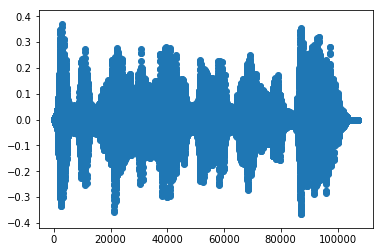

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(list(range(len(data))),data)

In [31]:
sf.write('spedup.wav',data,44100)

In [28]:
sr

22050